# 02_eda – Data Expoloration Analyses: Exploration and basic cleaning of New Jersey home sales

This notebook loads the raw New Jersey home sales dataset created in
`01_query.ipynb`, performs exploratory data analysis, and applies basic
cleaning steps to define a first-pass modeling dataset.

The goals are to:

1. Inspect the structure of the raw data (columns, dtypes, coverage).
2. Confirm temporal coverage (earliest and latest sale dates).
3. Examine key numeric features (sale price, list price, bedrooms, bathrooms,
   square footage, year built, lot size) for outliers and missingness.
4. Formulate simple, explicit rules to remove clearly invalid or extreme
   values.
5. Save a cleaned dataset to `data/processed/` for downstream modeling.


## Imports and configuration

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Detect whether we're running in Colab
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Colab: mount Google Drive and point PROJECT_ROOT to your repo
    from google.colab import drive  # type: ignore
    drive.mount("/content/drive", force_remount=False)

    PROJECT_ROOT = Path("/content/drive/My Drive/SH").resolve()
    DATA_DIR = PROJECT_ROOT / "data"
    RAW_DIR = DATA_DIR / "raw"
    PROC_DIR = DATA_DIR / "processed"
else:
    # Local / non-Colab: infer paths from src/paths.py
    from src.paths import get_project_paths

    paths = get_project_paths()
    PROJECT_ROOT = paths["PROJECT_ROOT"]
    DATA_DIR = paths["DATA_DIR"]
    RAW_DIR = paths["RAW_DIR"]
    PROC_DIR = paths["PROC_DIR"]

# Ensure PROJECT_ROOT is on sys.path so "src" is importable
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# EDA helpers from src
from src.eda_helpers import *

# Make sure processed directory exists for later
PROC_DIR.mkdir(parents=True, exist_ok=True)

# Path to raw dataset (output of 01_query.ipynb)
RAW_DATA_PATH = RAW_DIR / "redfin_nj_sold_2015-01-01_to_2025-11-24.csv"

print("IN_COLAB     :", IN_COLAB)
print("PROJECT_ROOT :", PROJECT_ROOT)
print("RAW_DIR      :", RAW_DIR)
print("PROC_DIR     :", PROC_DIR)
if not RAW_DATA_PATH.exists():
    raise FileNotFoundError(
        f"Raw file not found at {RAW_FILE}.\n"
        "Make sure 01.query.ipynb has been run and the file is saved under data/raw/."
    )
print("RAW_DATA_PATH:", RAW_DATA_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
IN_COLAB     : True
PROJECT_ROOT : /content/drive/My Drive/SH
RAW_DIR      : /content/drive/My Drive/SH/data/raw
PROC_DIR     : /content/drive/My Drive/SH/data/processed
RAW_DATA_PATH: /content/drive/My Drive/SH/data/raw/redfin_nj_sold_2015-01-01_to_2025-11-24.csv


## Load raw dataset

Load the de-duplicated raw CSV produced by `01_query.ipynb` and
inspect its basic structure.


In [5]:
# Load raw Redfin data (output from 01.query.ipynb)
df_raw = pd.read_csv(RAW_DATA_PATH, dtype={"zip_code": str}) # Designate zip_code as string, otherwise it'll be defaultly recognized by pandas as numeric (codes such as 07001 will be imported as 7001.0)

/tmp/ipython-input-2007056903.py:2: DtypeWarning: Columns (5,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(RAW_DATA_PATH, dtype={"zip_code": str}) # Designate zip_code as string, otherwise it'll be defaultly recognized by pandas as numeric (codes such as 07001 will be imported as 7001.0)


In [6]:
# Check the shape of raw data, and preview
df_raw.shape, df_raw.head()

((188822, 64),
                                         property_url  property_id  listing_id  \
 0  https://www.realtor.com/realestateandhomes-det...   6768574319   605279890   
 1  https://www.realtor.com/realestateandhomes-det...   5693347416   603967502   
 2  https://www.realtor.com/realestateandhomes-det...   5263273403   603969258   
 3  https://www.realtor.com/realestateandhomes-det...   5286455447   610063262   
 4  https://www.realtor.com/realestateandhomes-det...   5153179323   640820846   
 
                                            permalink   mls      mls_id status  \
 0     20-Pine-Glen-Dr_Jobstown_NJ_08041_M67685-74319  PHPA     6623830   SOLD   
 1    28-Jake-Dr_Upper-Freehold_NJ_08501_M56933-47416  MONJ    21525341   SOLD   
 2       28-Jake-Dr_Cream-Ridge_NJ_08514_M52632-73403  PHPA     6600967   SOLD   
 3  1879-Old-Cuthbert-Rd-Ste-38_Cherry-Hill_NJ_080...  PHPA     6614636   SOLD   
 4  334-Perkintown-Rd_Pedricktown_NJ_08067_M51531-...  PHPA  1001798217   SOLD   

In [7]:
# check the dtype of each colum
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188822 entries, 0 to 188821
Data columns (total 64 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   property_url       188822 non-null  object 
 1   property_id        188822 non-null  int64  
 2   listing_id         188822 non-null  int64  
 3   permalink          188822 non-null  object 
 4   mls                188822 non-null  object 
 5   mls_id             188822 non-null  object 
 6   status             188822 non-null  object 
 7   mls_status         180595 non-null  object 
 8   text               178804 non-null  object 
 9   style              188822 non-null  object 
 10  formatted_address  188822 non-null  object 
 11  full_street_line   188283 non-null  object 
 12  street             188284 non-null  object 
 13  unit               4297 non-null    object 
 14  city               188671 non-null  object 
 15  state              188822 non-null  object 
 16  zi

## Identify key columns: prices and dates

From the column list, the relevant price and date fields are:

- `sold_price`: sale price for the transaction associated with this record.
- `last_sold_price`: also populated for all records, but redundant with `sold_price`
  for this analysis.
- `list_price`: list price for the current sale.
- `last_sold_date`: sale/closing date for the current transaction.
- `list_date`: date the property was listed.

For modeling home sale prices, I:

- treat `sold_price` as the target sale price,
- further calculate `log_sod_price` as target sales price
- treat `last_sold_date` as the sale date.

I keep `list_price` mainly for diagnostics and exploration.


In [8]:
SALE_PRICE_COL = "sold_price"
LIST_PRICE_COL = "list_price"
SALE_DATE_COL  = "last_sold_date"
LIST_DATE_COL  = "list_date"

# Quick sanity check: non-null counts
df_raw[[SALE_PRICE_COL, LIST_PRICE_COL, SALE_DATE_COL, LIST_DATE_COL]].isna().sum()


,0
sold_price,4
list_price,142
last_sold_date,0
list_date,1


## Temporal coverage

I convert the sale date and list date columns to datetime and then confirm the
earliest and latest dates in the dataset, as well as the number of
entries by year.

In [9]:
df = df_raw.copy()

df[SALE_DATE_COL] = pd.to_datetime(df[SALE_DATE_COL], errors="coerce")
df[LIST_DATE_COL] = pd.to_datetime(df[LIST_DATE_COL], errors="coerce")

print("Sale date range:")
print("  min:", df[SALE_DATE_COL].min())
print("  max:", df[SALE_DATE_COL].max())

print("\nList date range:")
print("  min:", df[LIST_DATE_COL].min())
print("  max:", df[LIST_DATE_COL].max())


Sale date range:
  min: 2015-11-14 00:00:00
  max: 2025-11-24 00:00:00

List date range:
  min: 2009-09-08 07:00:00
  max: 2025-11-24 20:51:00


In [10]:
# Entries per year (based on sale date)
df["sale_year"] = df[SALE_DATE_COL].dt.year
df["sale_year"].value_counts().sort_index()


,count
sale_year,
2015,1717
2016,12773
2017,13297
2018,12543
2019,15020
2020,18896
2021,14712
2022,17097
2023,29731


## Missing values overview

Next, I quantify missing values across all columns and look at the most and least
complete variables. Some columns are entirely empty (e.g. `list_price_min`,
`list_price_max`, `neighborhoods`, `builder_name`) and can be excluded.


In [11]:
missing_counts = df.isna().sum()
missing_frac = missing_counts / len(df)

missing_summary = (
    pd.DataFrame({
        "missing_count": missing_counts,
        "missing_fraction": missing_frac
    })
    .sort_values("missing_fraction", ascending=False)
)

missing_summary.head(20)


,missing_count,missing_fraction
list_price_max,188822,1.000000
builder_name,188822,1.000000
list_price_min,188822,1.000000
neighborhoods,188822,1.000000
builder_id,188811,0.999942
unit,184525,0.977243
pending_date,140060,0.741757
days_on_mls,109274,0.578714
half_baths,101930,0.539821
price_per_sqft,71354,0.377890


In [12]:
print("Columns with 100% missing values:")
missing_summary.query("missing_fraction == 1.0")


Columns with 100% missing values:


,missing_count,missing_fraction
list_price_max,188822,1.0
builder_name,188822,1.0
list_price_min,188822,1.0
neighborhoods,188822,1.0


In [13]:
cols_all_missing = missing_summary.index[missing_summary["missing_fraction"] == 1.0].tolist()
cols_all_missing

['list_price_max', 'builder_name', 'list_price_min', 'neighborhoods']

### Missingness bar plot

Visualize the fraction of missing values per column

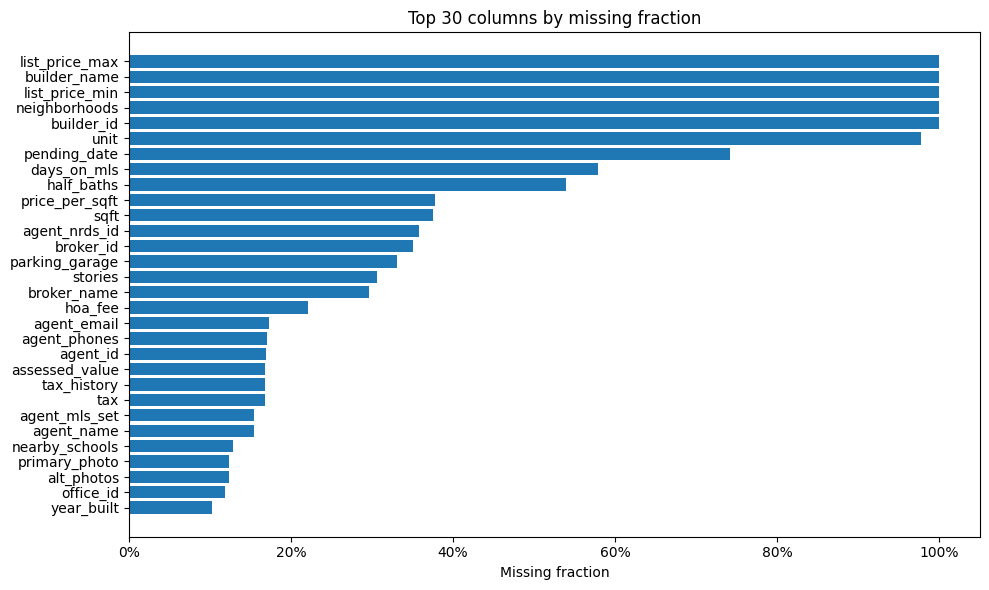

In [26]:
# Bar chart of missing fractions

top_n = 30

missing_plot = (
    missing_summary
    .head(top_n)
    .reset_index()
    .rename(columns={"index": "column"})
)

plt.figure(figsize=(10, 6))
plt.barh(
    missing_plot["column"],
    missing_plot["missing_fraction"]
)
plt.gca().invert_yaxis()  # highest missing at top
plt.xlabel("Missing fraction")
plt.title(f"Top {top_n} columns by missing fraction")

# Optional: format x-axis as percentage
plt.gca().xaxis.set_major_formatter(
    plt.FuncFormatter(lambda v, _: f"{v:.0%}")
)

plt.tight_layout()
plt.show()


## Drop fully empty or non-informative columns

Several columns are completely empty (e.g. `list_price_min`, `list_price_max`,
`neighborhoods`, `builder_name`). I drop these here to simplify subsequent exploration.

This step does **not** remove any rows; it only removes columns that carry no
useful information.


In [14]:
# Columns that are completely empty in this snapshot
cols_all_missing = missing_summary.index[missing_summary["missing_fraction"] == 1.0].tolist()

# Additional high-noise / non-tabular columns we know we won't model with
cols_to_drop_extra = [
    "property_url",
    "permalink",
    "tax_history",
    "agent_phones",
    "office_phones",
    #"primary_photo",
    #"alt_photos",
]

cols_to_drop = sorted(set(cols_all_missing + cols_to_drop_extra))

print("Dropping the following columns:")
cols_to_drop


Dropping the following columns:


['agent_phones',
 'builder_name',
 'list_price_max',
 'list_price_min',
 'neighborhoods',
 'office_phones',
 'permalink',
 'property_url',
 'tax_history']

In [15]:
df = df.drop(columns=cols_to_drop)
df.shape

(188822, 56)

## Exploration of key numeric features

Here I examine distributions and quantiles for the main numeric predictors:

- `sold_price` (target)
- `list_price` (for diagnostics)
- `beds`, `full_baths`, `half_baths`
- `sqft`, `lot_sqft`
- `year_built`

This helps define reasonable thresholds for removing clearly invalid or extreme
values.


In [16]:
print_quantiles(df[SALE_PRICE_COL], "Sold price")
print_quantiles(df[LIST_PRICE_COL], "List price")

for col in ["beds", "full_baths", "half_baths", "sqft", "lot_sqft", "year_built", "hoa_fee"]:
    if col in df.columns:
        print_quantiles(df[col], col)



Sold price – basic stats
  count: 188818
  min:   1
  max:   25,000,000
  quantiles:
     1th: 35,000
     5th: 115,900
    25th: 285,000
    50th: 440,000
    75th: 656,022
    95th: 1,300,000
    99th: 2,500,000

List price – basic stats
  count: 188680
  min:   1
  max:   25,000,000
  quantiles:
     1th: 39,900
     5th: 120,000
    25th: 287,900
    50th: 435,000
    75th: 649,900
    95th: 1,295,000
    99th: 2,550,000

beds – basic stats
  count: 187472
  min:   0
  max:   76
  quantiles:
     1th: 1
     5th: 2
    25th: 3
    50th: 3
    75th: 4
    95th: 5
    99th: 7

full_baths – basic stats
  count: 185747
  min:   1
  max:   212
  quantiles:
     1th: 1
     5th: 1
    25th: 1
    50th: 2
    75th: 2
    95th: 4
    99th: 5

half_baths – basic stats
  count: 86892
  min:   0
  max:   12
  quantiles:
     1th: 1
     5th: 1
    25th: 1
    50th: 1
    75th: 1
    95th: 2
    99th: 2

sqft – basic stats
  count: 117967
  min:   0
  max:   653,400
  quantiles:
     1th: 660

## For ourliers: data-driven cleaning rules

Using the quantiles above, I define simple rules to remove clearly
invalid or extreme values while keeping the bulk of the distribution.

The guiding principle is:

- Use the **1st and 99th percentiles** as anchors.
- Extend the retained range slightly beyond these percentiles, so that only the
  most extreme tails and obvious errors are removed.

The rules are:

- **Sold price (`sold_price`)**

  - 1st percentile ≈ \$35k, 99th percentile ≈ \$2.5M, max = \$25M.
  - I keep properties with `sold_price` between **\$30,000** and **\$3,000,000**.
    - \$30k is slightly below the 1st percentile but well above the clearly
      invalid value of 1.
    - \$3M is above the 99th percentile, so only the most extreme tail (and
      obvious outliers) is removed.
  - Rows with missing `sold_price` are dropped.

- **Bedrooms (`beds`)**

  - 1st percentile = 1, 99th percentile = 7, max = 76.
  - I allow properties with **0–8 bedrooms**:
    - 0 covers studio units.
    - 8 gives a small buffer above the 99th percentile.
  - `beds` may be missing; missing values are allowed to pass this filter.

- **Full bathrooms (`full_baths`)**

  - 99th percentile = 5, max = 212.
  - I keep properties with **1–6 full baths**, dropping extreme values > 6.

- **Half bathrooms (`half_baths`)**

  - 99th percentile = 2, max = 12.
  - I keep properties with **0–3 half baths**, dropping extreme values > 3.

- **Square footage (`sqft`)**

  - 1st percentile ≈ 660 sqft, 99th percentile ≈ 7,000 sqft, max = 653,400 sqft.
  - I keep properties with `sqft` between **400** and **10,000**:
    - 400 sqft is slightly below the 1st percentile but above clearly
      non-residential/placeholder values like 0.
    - 10,000 sqft is comfortably above the 99th percentile, so only the most
      extreme outliers are removed.
  - Missing `sqft` is allowed to pass this filter (to be handled later via
    imputation or exclusion, depending on the modeling strategy).

- **Lot size in square feet (`lot_sqft`)**

  - 1st percentile ≈ 1,307 sqft, 99th percentile ≈ 314,503 sqft,
    max ≈ 4.36 billion sqft.
  - The maximum clearly reflects erroneous or non-comparable values.
  - I keep properties with `lot_sqft` between **500** and **1,000,000** sqft:
    - 500 removes obviously invalid zeros.
    - 1,000,000 is well above the 99th percentile and removes only the
      extremely large tail, including the pathological 4.36 billion sqft value.
  - Missing `lot_sqft` is allowed.

- **Year built (`year_built`)**

  - 1st percentile ≈ 1877, 99th percentile ≈ 2023, min = 1000, max = 2045.
  - I keep `year_built` between **1850** and **2025**:
    - 1850 is below the 1st percentile but above obviously implausible values
      like 1000.
    - 2025 removes future or placeholder years beyond the data snapshot.
  - Missing `year_built` is allowed.

- **Sale year (`sale_year`)**

  - The raw query requested data from 2015 onward, but the earliest non-empty
    chunks start in late 2015 and counts for 2015 are relatively small.
  - To focus on a more stable recent market, I retain transactions with
    `sale_year ≥ 2016`.

- **HOA fee (`hoa_fee`)**
  
  - 99th percentile = 430 but max = 318,332
  - I keep `hoa_fee` between 0 and 428:
      
      - 0 makes sence for single family homes
      - 1,000 is greater than the 99th percentile but below the obviously wrong value instead 318,332


These rules are intentionally simple and grounded in the observed quantiles.
They remove obviously bad data and extreme tails while preserving the bulk of
the New Jersey residential market.


In [17]:
# Define cutoffs
# --- 1. Sold price filter ---
price_min = 30_000
price_max = 3_000_000

mask_price = (
    df[SALE_PRICE_COL].notna()
    & df[SALE_PRICE_COL].between(price_min, price_max)
)


# --- 2. Bedrooms filter ---
if "beds" in df.columns:
    beds_min = 0
    beds_max = 8
    mask_beds = df["beds"].between(beds_min, beds_max) | df["beds"].isna()
else:
    mask_beds = pd.Series(True, index=df.index)


# --- 3. Full bathrooms filter ---
if "full_baths" in df.columns:
    full_baths_min = 1
    full_baths_max = 6
    mask_full_baths = (
        df["full_baths"].between(full_baths_min, full_baths_max)
        | df["full_baths"].isna()
    )
else:
    mask_full_baths = pd.Series(True, index=df.index)


# --- 4. Half bathrooms filter ---
if "half_baths" in df.columns:
    half_baths_min = 0
    half_baths_max = 3
    mask_half_baths = (
        df["half_baths"].between(half_baths_min, half_baths_max)
        | df["half_baths"].isna()
    )
else:
    mask_half_baths = pd.Series(True, index=df.index)


# --- 5. Square footage filter ---
if "sqft" in df.columns:
    sqft_min = 400
    sqft_max = 10_000
    mask_sqft = df["sqft"].between(sqft_min, sqft_max) | df["sqft"].isna()
else:
    mask_sqft = pd.Series(True, index=df.index)


# --- 6. Lot size filter ---
if "lot_sqft" in df.columns:
    lot_sqft_min = 500
    lot_sqft_max = 1_000_000
    mask_lot_sqft = (
        df["lot_sqft"].between(lot_sqft_min, lot_sqft_max)
        | df["lot_sqft"].isna()
    )
else:
    mask_lot_sqft = pd.Series(True, index=df.index)


# --- 7. Year built filter ---
if "year_built" in df.columns:
    year_built_min = 1850
    year_built_max = 2025
    mask_year_built = (
        df["year_built"].between(year_built_min, year_built_max)
        | df["year_built"].isna()
    )
else:
    mask_year_built = pd.Series(True, index=df.index)


# --- 8. Sale year filter ---
if "sale_year" in df.columns:
    sale_year_min = 2016
    mask_sale_year = df["sale_year"] >= sale_year_min
else:
    mask_sale_year = pd.Series(True, index=df.index)

# --- 9. HOA filter ---
if "hoa_fee" in df.columns:
    hoa_fee_min = 0
    hoa_fee_max = 430
    mask_hoa_fee = (
        df["hoa_fee"].between(hoa_fee_min, hoa_fee_max)
        | df["hoa_fee"].isna()
    )
else:
    mask_hoa_fee = pd.Series(True, index=df.index)


# --- Combine all masks ---
combined_mask = (
    mask_price
    & mask_beds
    & mask_full_baths
    & mask_half_baths
    & mask_sqft
    & mask_lot_sqft
    & mask_year_built
    & mask_sale_year
    & mask_hoa_fee
)

df_clean = df.loc[combined_mask].copy()
df_clean.shape


(179598, 56)

In [18]:
# check number of entries after apply each filter
n_total = len(df)

summary_cleaning = pd.Series({
    "total_raw_rows": n_total,
    "kept_after_price": int(mask_price.sum()),
    "kept_after_beds": int(mask_beds.sum()),
    "kept_after_full_baths": int(mask_full_baths.sum()),
    "kept_after_half_baths": int(mask_half_baths.sum()),
    "kept_after_sqft": int(mask_sqft.sum()),
    "kept_after_lot_sqft": int(mask_lot_sqft.sum()),
    "kept_after_year_built": int(mask_year_built.sum()),
    "kept_after_sale_year": int(mask_sale_year.sum()),
    "total_after_all_filters": len(df_clean),
})

summary_cleaning


,0
total_raw_rows,188822
kept_after_price,186288
kept_after_beds,188119
kept_after_full_baths,188425
kept_after_half_baths,188723
kept_after_sqft,187502
kept_after_lot_sqft,187816
kept_after_year_built,188033
kept_after_sale_year,187105
total_after_all_filters,179598


In [19]:
# Final sanity checks on the cleaned dataset

print("Cleaned dataset shape:", df_clean.shape)

print("\nSold price (cleaned):")
display(df_clean[SALE_PRICE_COL].describe())

for col in ["beds", "full_baths", "half_baths", "sqft", "lot_sqft", "year_built"]:
    if col in df_clean.columns:
        print_quantiles(df_clean[col], f"{col} (cleaned)")


Cleaned dataset shape: (179598, 56)

Sold price (cleaned):


,sold_price
count,1.795980e+05
mean,5.270593e+05
std,3.757823e+05
min,3.000000e+04
25%,2.900000e+05
50%,4.400000e+05
75%,6.500000e+05
max,3.000000e+06



beds (cleaned) – basic stats
  count: 178383
  min:   0
  max:   8
  quantiles:
     1th: 1
     5th: 2
    25th: 3
    50th: 3
    75th: 4
    95th: 5
    99th: 7

full_baths (cleaned) – basic stats
  count: 176988
  min:   1
  max:   6
  quantiles:
     1th: 1
     5th: 1
    25th: 1
    50th: 2
    75th: 2
    95th: 4
    99th: 5

half_baths (cleaned) – basic stats
  count: 83270
  min:   0
  max:   3
  quantiles:
     1th: 1
     5th: 1
    25th: 1
    50th: 1
    75th: 1
    95th: 2
    99th: 2

sqft (cleaned) – basic stats
  count: 112040
  min:   400
  max:   10,000
  quantiles:
     1th: 736
     5th: 984
    25th: 1,410
    50th: 1,872
    75th: 2,500
    95th: 3,895
    99th: 5,474

lot_sqft (cleaned) – basic stats
  count: 162730
  min:   514
  max:   998,001
  quantiles:
     1th: 1,585
     5th: 3,000
    25th: 6,098
    50th: 9,750
    75th: 19,166
    95th: 81,022
    99th: 242,194

year_built (cleaned) – basic stats
  count: 161756
  min:   1,850
  max:   2,025
  quant

## Macro feature: Federal Funds Rate (FEDFUNDS)

Here I augment the cleaned dataset with a macroeconomic feature, the daily
effective Federal Funds Rate from FRED.

Steps:

1. Load `../data/raw/FEDFUNDS_151001_to_251001.csv` (columns
   `observation_date`, `FEDFUNDS`).
2. Resample the series to daily frequency with forward fill.
3. Parse `last_sold_date` in `df_clean` into a normalized `sale_date`.
4. Join the daily FEDFUNDS series onto `df_clean` by `sale_date` and store the
   rate as `fed_funds_rate`.
5. Re-save the cleaned dataset including this new column.


In [21]:
# FEDFUNDS macro data: load and merge onto cleaned dataset

# Path to FEDFUNDS data (stored under data/raw/)
FEDFUNDS_PATH = RAW_DIR / "FEDFUNDS_151001_to_251001.csv"

# Load FEDFUNDS
df_fed = pd.read_csv(FEDFUNDS_PATH)

# Parse and sort dates
df_fed["observation_date"] = pd.to_datetime(df_fed["observation_date"], errors="coerce")
df_fed = df_fed.sort_values("observation_date")

# Resample to daily frequency with forward fill
df_fed_daily = (
    df_fed
    .set_index("observation_date")["FEDFUNDS"]
    .resample("D")
    .ffill()
    .reset_index()
)

df_fed_daily.rename(columns={"FEDFUNDS": "fed_funds_rate"}, inplace=True)

print("FEDFUNDS daily coverage:")
print("  min date:", df_fed_daily["observation_date"].min())
print("  max date:", df_fed_daily["observation_date"].max())

# Align property data by sale date
df_clean["last_sold_date"] = pd.to_datetime(df_clean["last_sold_date"], errors="coerce")
df_clean["sale_date"] = df_clean["last_sold_date"].dt.normalize()

# Merge FEDFUNDS onto df_clean
df_clean = df_clean.merge(
    df_fed_daily,
    left_on="sale_date",
    right_on="observation_date",
    how="left"
)

df_clean = df_clean.drop(columns=["observation_date"])

df_clean[["sale_date", "fed_funds_rate"]].head()


FEDFUNDS daily coverage:
  min date: 2015-10-01 00:00:00
  max date: 2025-10-01 00:00:00


,sale_date,fed_funds_rate
0,2016-03-25,0.36
1,2016-03-25,0.36
2,2016-03-25,0.36
3,2016-03-25,0.36
4,2016-03-25,0.36


In [22]:
# Quick sanity check of new column
df_clean[["sold_price", "sale_date", "fed_funds_rate"]].head()

,sold_price,sale_date,fed_funds_rate
0,175000.0,2016-03-25,0.36
1,340000.0,2016-03-25,0.36
2,248000.0,2016-03-25,0.36
3,239900.0,2016-03-25,0.36
4,191500.0,2016-03-25,0.36


In [23]:
# Save the cleaned dataset to data/processed/

CLEAN_FILE = PROC_DIR / "redfin_nj_sold_2016plus_basic_clean.csv"  # sale_year >= 2016

df_clean.to_csv(CLEAN_FILE, index=False)
print("Saved cleaned dataset to:", CLEAN_FILE)

Saved cleaned dataset to: /content/drive/My Drive/SH/data/processed/redfin_nj_sold_2016plus_basic_clean.csv


## Summary of 02_eda – cleaned modeling cohort

In this notebook, I loaded the de-duplicated raw New Jersey home sales dataset
produced by `01_query.ipynb` and constructed a first-pass modeling cohort.

Key steps:

- **Input data**
  - Source: `data/raw/redfin_nj_sold_2015-01-01_to_2025-11-24.csv`
  - Size after de-duplication in `01_query.ipynb`: **188,822** records and 64 columns.
  - Effective temporal coverage: late **2015** through **2025-11-24**.

- **Column-level filtering**
  - Dropped columns that were completely empty in this snapshot (e.g.
    `list_price_min`, `list_price_max`, `neighborhoods`, `builder_name`).
  - Dropped high-noise, non-tabular fields such as URLs, and
    complex nested structures that are not directly useful for tabular
    modeling (e.g. `property_url`, `tax_history`, `agent_phones`, `office_phones).

- **Data-driven cleaning rules on key variables**
  - Anchored thresholds to the **1st and 99th percentiles** of the observed
    distributions and extended them slightly to remove only the most extreme
    tails and clearly invalid entries:
    - `sold_price` between **\$30,000** and **\$3,000,000** (dropping obvious errors
      like \$1 sales and extremely high outliers).
    - `beds` between **0 and 8** (allowing studios but excluding values such as 76).
    - `full_baths` between **1 and 6**, `half_baths` between **0 and 3**.
    - `sqft` between **400 and 10,000** or missing (removing 0 sqft and very large
      outliers such as 653,400 sqft).
    - `lot_sqft` between **500 and 1,000,000** or missing (trimming the extreme
      upper tail including the multi-billion sqft values).
    - `year_built` between **1850 and 2024** or missing (excluding implausible
      years like 1000 or future years).
    - `sale_year ≥ 2016` to focus on a more recent and stable market period.
    - `hoa_fee` between **0 and 1000** to focus on a more reasonable HOA range here in NJ.

- **Effect on dataset size**
  - Starting from **188,822** de-duplicated records, the combined filters retain
    **179,598** rows (≈ **95.1%** of the data).
  - The majority of dropped rows correspond to:
    - Extreme or clearly invalid sale prices.
    - Pathological square footage or lot sizes.
    - A small number of implausible construction years.
    - Transactions before 2016.

- **Output**
  - The cleaned cohort has been saved to:

    `data/processed/redfin_nj_sold_2016plus_basic_clean.csv`

This file defines the modeling cohort for subsequent notebooks, where I will:

1. Select and engineer features suitable for predicting `sold_price`.
2. Handle remaining missing values and encode categorical variables.
3. Split the data into training/validation/test sets and fit predictive models.


In [32]:
# sanity preview of the cleaned data frame
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

df_clean.head()

,property_id,listing_id,mls,mls_id,status,mls_status,text,style,formatted_address,full_street_line,street,unit,city,state,zip_code,beds,full_baths,half_baths,sqft,year_built,days_on_mls,list_price,list_date,pending_date,sold_price,last_sold_date,last_sold_price,assessed_value,estimated_value,tax,new_construction,lot_sqft,price_per_sqft,latitude,longitude,county,fips_code,stories,hoa_fee,parking_garage,agent_id,agent_name,agent_email,agent_mls_set,agent_nrds_id,broker_id,broker_name,builder_id,office_id,office_mls_set,office_name,office_email,nearby_schools,primary_photo,alt_photos,sale_year,sale_date,fed_funds_rate
0,5754206921,607885106,PHPA,6660669,SOLD,S,NaN,SINGLE_FAMILY,"32 Graypebble Cir, Gloucester Township, NJ, 08081",32 Graypebble Cir,32 Graypebble Cir,NaN,Gloucester Township,NJ,08081,4.0,2.0,1.0,2744.0,1993.0,175.0,200000.0,2015-10-01 07:00:00,NaN,175000.0,2016-03-25,175000.0,261700.0,533584.0,11643.0,False,22651.0,64.0,39.745878,-75.013755,Camden,34007.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6671.0,O-PHPA-YWEI05,Weichert Realtors,kcregan@weichertrealtors.net,"Gloucester Township Public School District, Ca...",https://ap.rdcpix.com/394545985/12e74c66487687...,https://ap.rdcpix.com/394545985/12e74c66487687...,2016,2016-03-25,0.36
1,5675790418,607857514,PHPA,6660228,SOLD,S,NaN,SINGLE_FAMILY,"125 Berry Ln, Mantua, NJ, 08051",125 Berry Ln,125 Berry Ln,NaN,Mantua,NJ,08051,5.0,2.0,1.0,3118.0,NaN,161.0,314900.0,2015-10-15 07:00:00,NaN,340000.0,2016-03-25,340000.0,NaN,NaN,NaN,False,26136.0,109.0,39.765873,-75.157565,Gloucester,34015.0,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1856188.0,O-PHPA-C21T&C-M,CENTURY 21 Town & Country Realty,301393.lead@cendant.leadrouter.com,Mantua Township Board Of Education School Dist...,https://ap.rdcpix.com/556202395/977ba8194667d8...,https://ap.rdcpix.com/556202395/977ba8194667d8...,2016,2016-03-25,0.36
2,6818424930,640737814,PHPA,1003970169,SOLD,NaN,"OPEN floor plan, Soaring ceilings, TWO master ...",SINGLE_FAMILY,"127 Patriots Ridge Dr, Deptford, NJ, 08096",127 Patriots Ridge Dr,127 Patriots Ridge Dr,NaN,Deptford,NJ,08096,3.0,2.0,1.0,2640.0,2001.0,48.0,250000.0,2016-02-05 07:00:00,NaN,248000.0,2016-03-25,248000.0,242000.0,484841.0,7581.0,False,11761.0,94.0,39.833875,-75.115859,Gloucester,34015.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O-PHPA-RMCONHA,Re/Max Connection,NaN,"Deptford Township Public School District, Glou...",NaN,NaN,2016,2016-03-25,0.36
3,5624446725,610900330,PHPA,6721469,SOLD,S,NaN,SINGLE_FAMILY,"107 Beechwood Dr, Mount Laurel, NJ, 08054",107 Beechwood Dr,107 Beechwood Dr,NaN,Mount Laurel,NJ,08054,4.0,1.0,1.0,1928.0,1967.0,63.0,239900.0,2016-01-21 07:00:00,NaN,239900.0,2016-03-25,239900.0,177000.0,434400.0,5587.0,False,14810.0,124.0,39.924850,-74.971312,Burlington,34005.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1450367.0,O-PHPA-CRMC01,RE/MAX Of Cherry Hill,rful@comcast.net,"Mount Laurel Township School District, Office ...",https://ap.rdcpix.com/670822559/accef73ba5c3d0...,https://ap.rdcpix.com/670822559/accef73ba5c3d0...,2016,2016-03-25,0.36
4,5779394998,607922282,MONJ,21540094,SOLD,Sold,This is a Fannie Mae HomePath property. It is ...,SINGLE_FAMILY,"3266 Oceanic Dr, Toms River, NJ, 08753",3266 Oceanic Dr,3266 Oceanic Dr,NaN,Toms River,NJ,08753,3.0,1.0,1.0,1524.0,1987.0,NaN,191500.0,2025-01-31 23:52:17,NaN,191500.0,2016-03-25,191500.0,367600.0,543500.0,7182.0,False,NaN,126.0,39.957155,-74.115495,Ocean,34029.0,2.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17252.0,O-MONJ-1185,"Diane Turton, Realtors - Point Pleasant Boro",lbusichio@dianeturton.com,"Toms River Regional School District, Office Of...",NaN,NaN,2016,2016-03-25,0.36


In [33]:
df_clean.columns

Index(['property_id', 'listing_id', 'mls', 'mls_id', 'status', 'mls_status', 'text', 'style', 'formatted_address', 'full_street_line', 'street', 'unit', 'city', 'state', 'zip_code', 'beds',
       'full_baths', 'half_baths', 'sqft', 'year_built', 'days_on_mls', 'list_price', 'list_date', 'pending_date', 'sold_price', 'last_sold_date', 'last_sold_price', 'assessed_value',
       'estimated_value', 'tax', 'new_construction', 'lot_sqft', 'price_per_sqft', 'latitude', 'longitude', 'county', 'fips_code', 'stories', 'hoa_fee', 'parking_garage', 'agent_id', 'agent_name',
       'agent_email', 'agent_mls_set', 'agent_nrds_id', 'broker_id', 'broker_name', 'builder_id', 'office_id', 'office_mls_set', 'office_name', 'office_email', 'nearby_schools', 'primary_photo',
       'alt_photos', 'sale_year', 'sale_date', 'fed_funds_rate'],
      dtype='object')

## Post hoc EDA on cleaned dataset

After saving the cleaned dataset, we perform additional exploratory analyses to:
- Visualize the distribution of sale prices and log sale prices.
- Examine correlations between numeric features and sale price.
- Inspect correlations among numeric features via a heatmap.
- Look at the distribution of key categorical features.
- Visualize boxplots of sale price by county and by house style.


### Distribution of sale prices and log-transformed sale prices

sold_price summary:


,sold_price
count,179598.0
mean,527059.0
std,375782.0
min,30000.0
25%,290000.0
50%,440000.0
75%,650000.0
max,3000000.0



log_sold_price summary:


,log_sold_price
count,179598.000
mean,12.956
std,0.687
min,10.309
25%,12.578
50%,12.995
75%,13.385
max,14.914


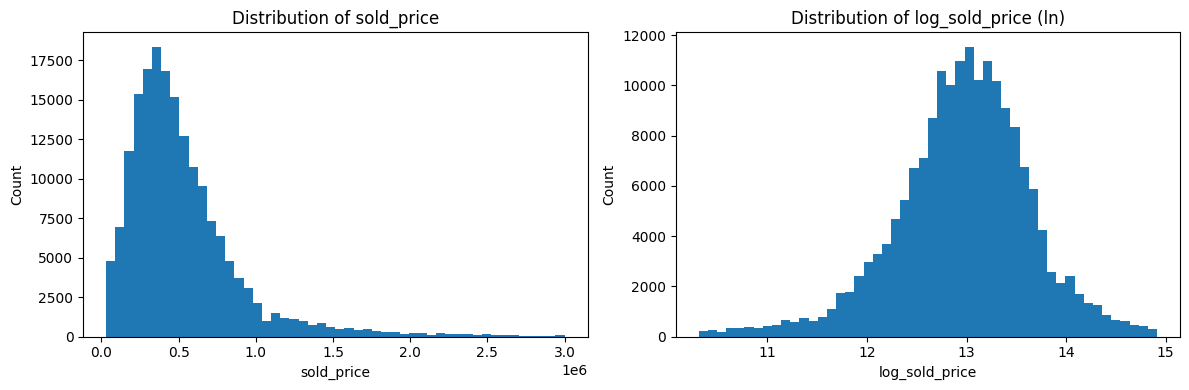

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure sold_price is present
if "sold_price" not in df_clean.columns:
    raise KeyError("Column 'sold_price' not found in df_clean.")

# Create a log-transformed sale price column (natural log)
df_clean["log_sold_price"] = np.log(df_clean["sold_price"])

print("sold_price summary:")
display(df_clean["sold_price"].describe().round(0))

print("\nlog_sold_price summary:")
display(df_clean["log_sold_price"].describe().round(3))

# Plot histograms side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Raw sale price
axes[0].hist(df_clean["sold_price"].dropna(), bins=50)
axes[0].set_title("Distribution of sold_price")
axes[0].set_xlabel("sold_price")
axes[0].set_ylabel("Count")

# Log-transformed sale price
axes[1].hist(df_clean["log_sold_price"].dropna(), bins=50)
axes[1].set_title("Distribution of log_sold_price (ln)")
axes[1].set_xlabel("log_sold_price")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


### Numeric feature correlations with sale price

Correlation of numeric features with sold_price (top 20):


,0
sold_price,1.000000
log_sold_price,0.872438
tax,0.667806
sqft,0.592554
full_baths,0.580789
beds,0.469449
sale_year,0.354545
latitude,0.269672
fed_funds_rate,0.264905
longitude,0.255467


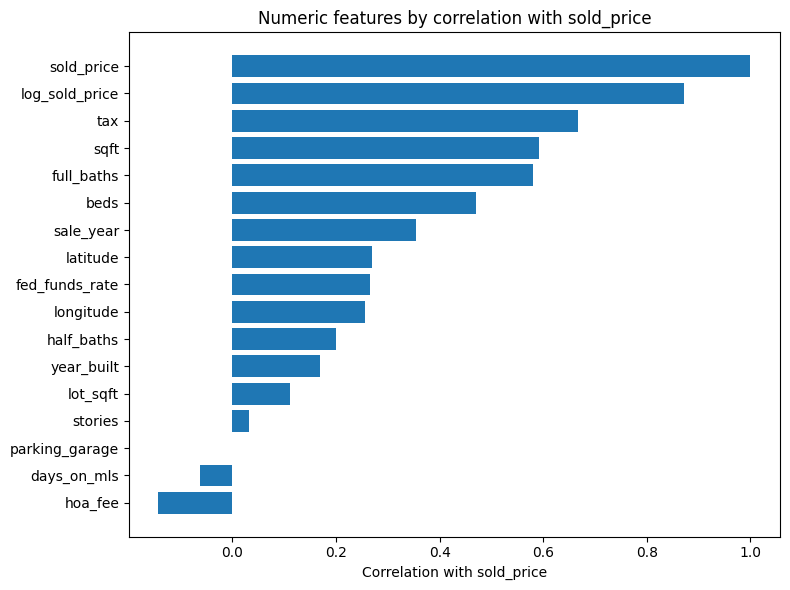

In [38]:
# Select numeric features and remove ID-like or leaky columns
df_numeric = df_clean.select_dtypes(include=["number"])

id_cols = [
    "property_id", "listing_id", "office_id", "fips_code", "agent_id",
    "agent_nrds_id", "broker_id", "builder_id",
    "last_sold_price", "list_price", "assessed_value",
    "estimated_value", "price_per_sqft"
]

# Filter out columns that are present in df_numeric
id_cols_to_drop = [col for col in id_cols if col in df_numeric.columns]

df_numeric_refined = df_numeric.drop(columns=id_cols_to_drop, errors="ignore")

# Correlations of numeric features with sold_price
corr_with_price = df_numeric_refined.corrwith(df_clean["sold_price"]).sort_values(ascending=False)

print("Correlation of numeric features with sold_price (top 20):")
display(corr_with_price.head(20))

# Bar plot correlations
corr_plot = corr_with_price.head(30)

plt.figure(figsize=(8, 6))
plt.barh(corr_plot.index[::-1], corr_plot.values[::-1])
plt.xlabel("Correlation with sold_price")
plt.title(f"Numeric features by correlation with sold_price")
plt.tight_layout()
plt.show()


### Heatmap of correlations among numeric features


Correlation Matrix (first 5 rows and columns):


,beds,full_baths,half_baths,sqft,year_built
beds,1.000000,0.586164,0.161041,0.591984,0.052762
full_baths,0.586164,1.000000,0.138483,0.703967,0.293164
half_baths,0.161041,0.138483,1.000000,0.217084,-0.029259
sqft,0.591984,0.703967,0.217084,1.000000,0.318842
year_built,0.052762,0.293164,-0.029259,0.318842,1.000000


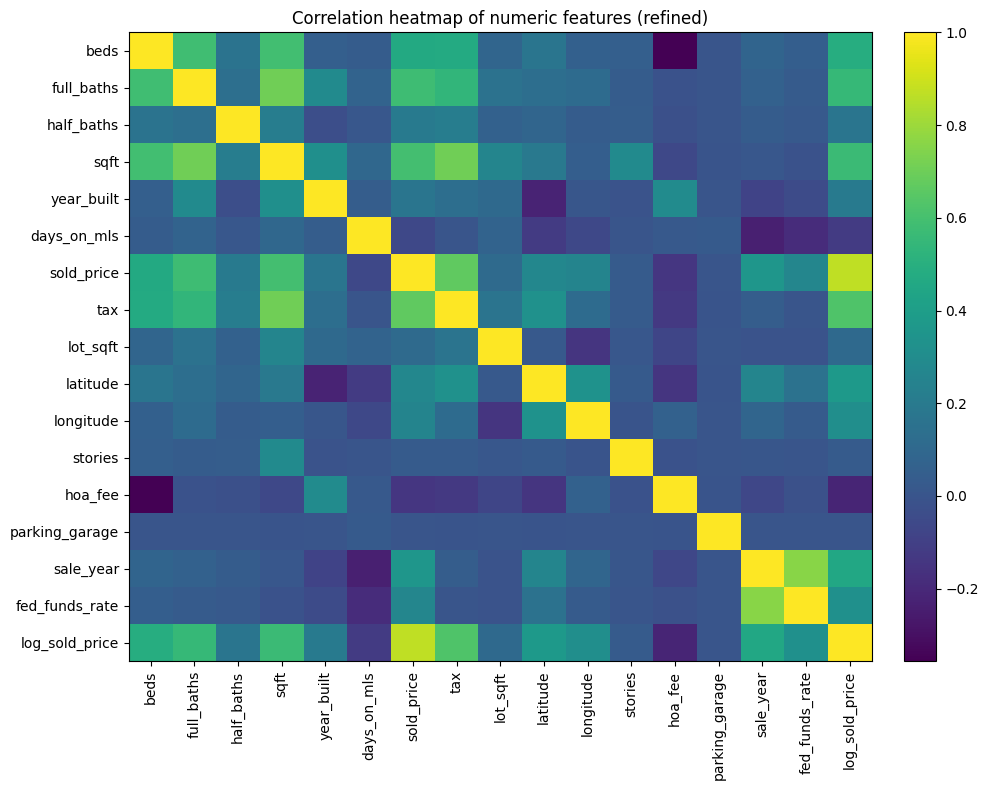

In [39]:
# Correlation matrix for refined numeric features
correlation_matrix = df_numeric_refined.corr()

print("Correlation Matrix (first 5 rows and columns):")
display(correlation_matrix.iloc[:5, :5])

# To keep the heatmap readable, optionally restrict to a subset of features.
# Here we use all refined numeric features; if it becomes too dense, consider
# selecting a subset manually.
plt.figure(figsize=(10, 8))
im = plt.imshow(correlation_matrix, aspect="auto", interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(
    ticks=range(len(correlation_matrix.columns)),
    labels=correlation_matrix.columns,
    rotation=90
)
plt.yticks(
    ticks=range(len(correlation_matrix.index)),
    labels=correlation_matrix.index
)
plt.title("Correlation heatmap of numeric features (refined)")
plt.tight_layout()
plt.show()


### Categorical feature distributions (bar plots)

Categorical columns:
['style', 'city', 'zip_code', 'county', 'nearby_schools']


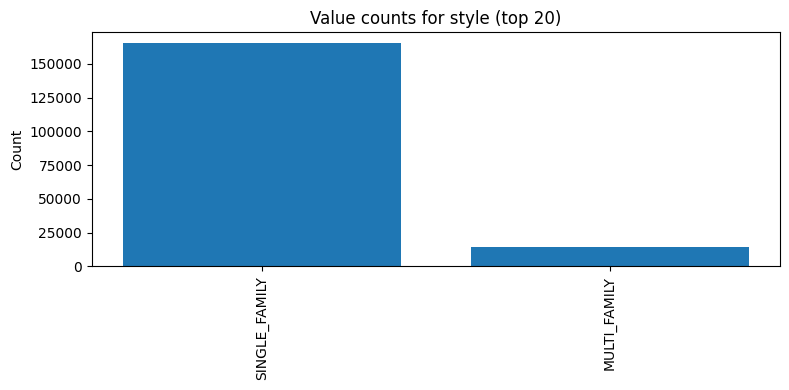

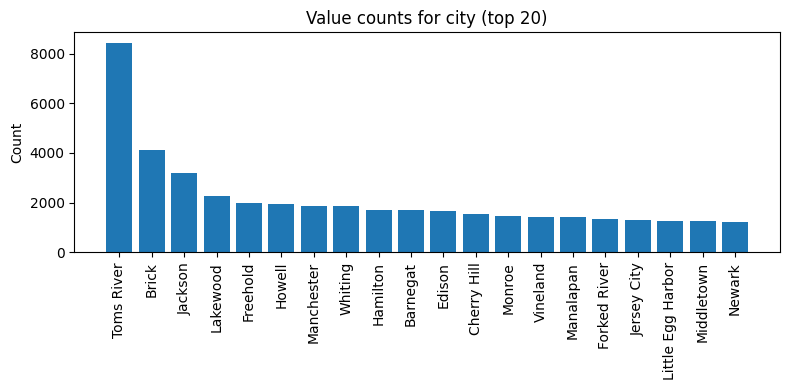

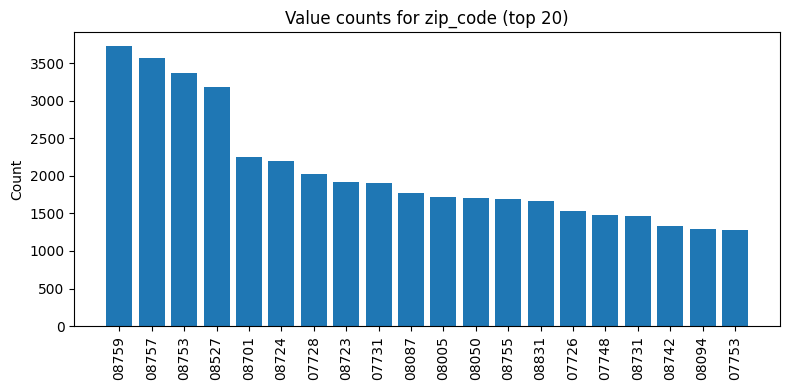

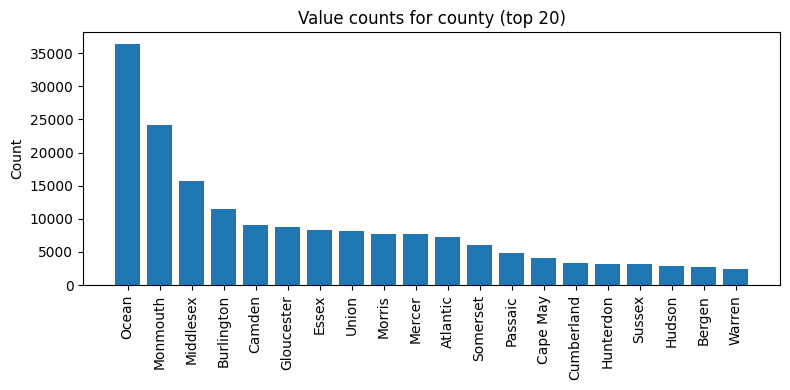

/tmp/ipython-input-214172193.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


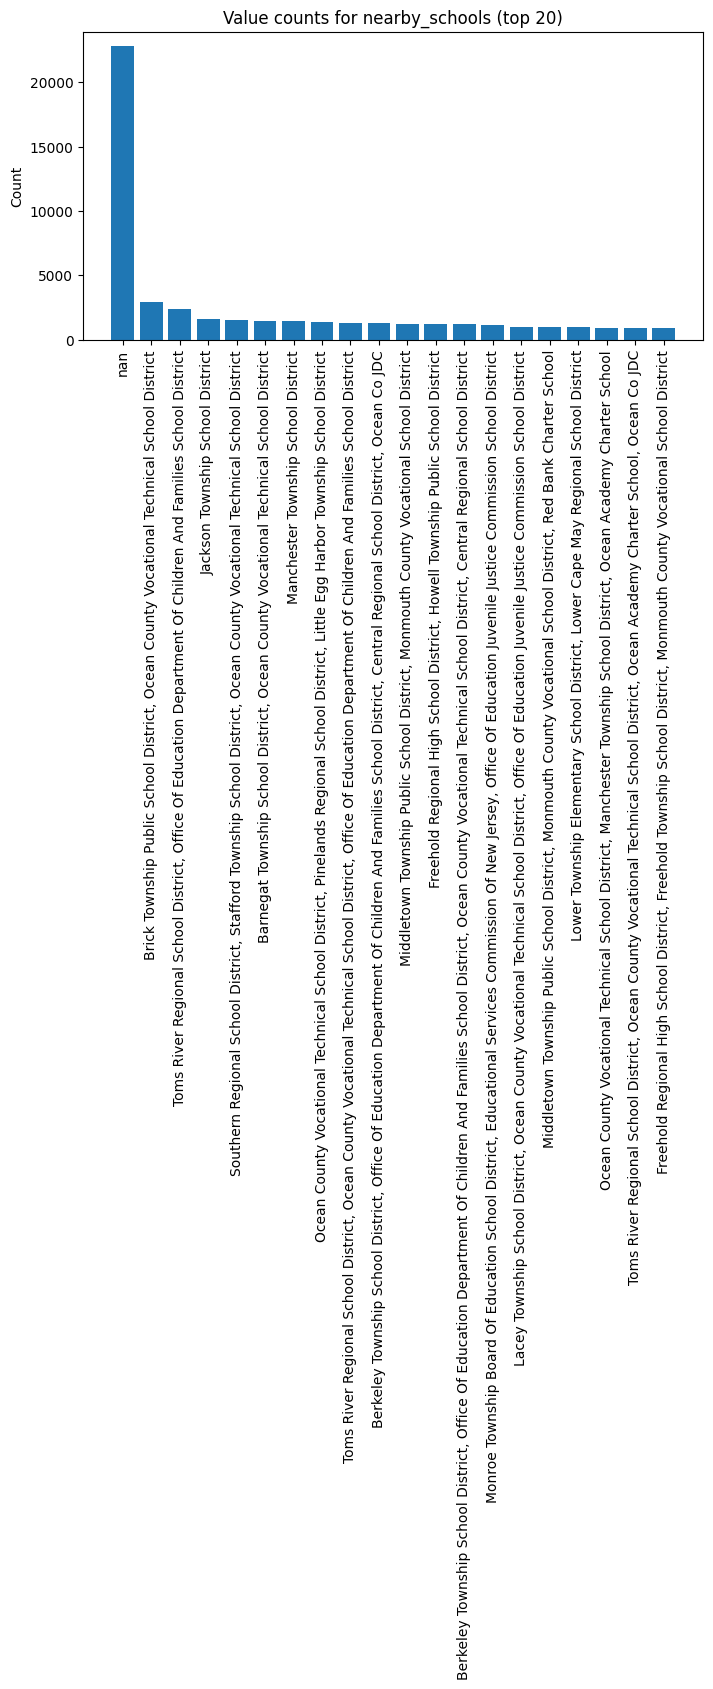

In [42]:
# Identify categorical / object columns
df_categorical = df_clean[['style', 'city', 'zip_code', 'county', 'nearby_schools']]

print("Categorical columns:")
print(df_categorical.columns.tolist())

# For each categorical column, plot the top categories (by count)
max_categories = 20  # limit to avoid overly crowded plots

for col in df_categorical.columns:
    value_counts = df_categorical[col].value_counts(dropna=False)
    top_values = value_counts.head(max_categories)

    plt.figure(figsize=(8, 4))
    plt.bar(top_values.index.astype(str), top_values.values)
    plt.xticks(rotation=90)
    plt.ylabel("Count")
    plt.title(f"Value counts for {col} (top {max_categories})")
    plt.tight_layout()
    plt.show()


### Box plots of sale price by county and by house style

<Figure size 1000x600 with 0 Axes>

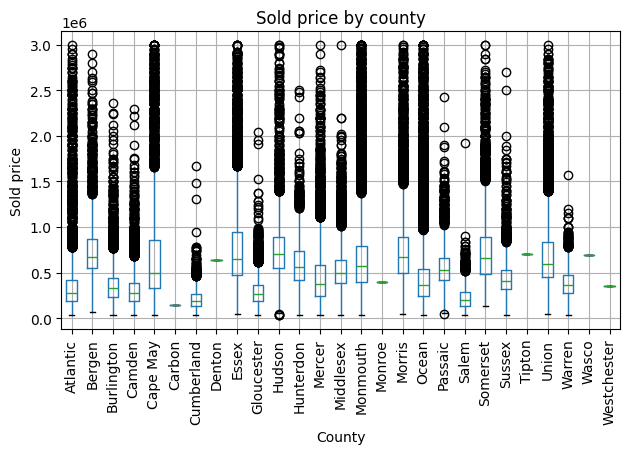

<Figure size 1000x600 with 0 Axes>

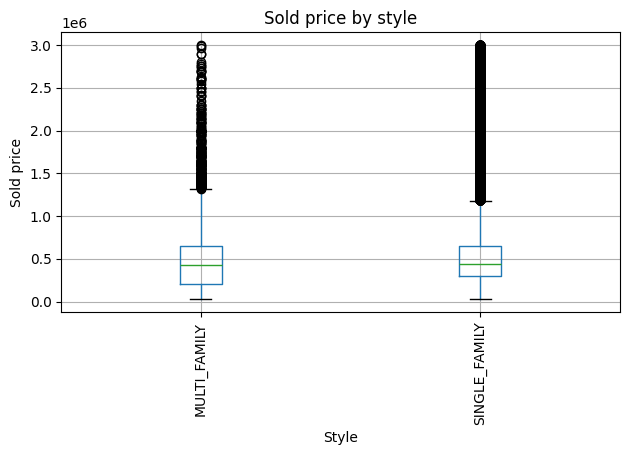

In [43]:
# Boxplot: sold_price by county
if {"sold_price", "county"}.issubset(df_clean.columns):
    # Keep only non-missing counties
    df_box_county = df_clean.dropna(subset=["sold_price", "county"])

    plt.figure(figsize=(10, 6))
    df_box_county.boxplot(column="sold_price", by="county", rot=90)
    plt.title("Sold price by county")
    plt.suptitle("")  # remove automatic pandas title
    plt.xlabel("County")
    plt.ylabel("Sold price")
    plt.tight_layout()
    plt.show()
else:
    print("Columns 'sold_price' and/or 'county' not found; skipping boxplot by county.")

# Boxplot: sold_price by house style
if {"sold_price", "style"}.issubset(df_clean.columns):
    df_box_style = df_clean.dropna(subset=["sold_price", "style"])

    plt.figure(figsize=(10, 6))
    df_box_style.boxplot(column="sold_price", by="style", rot=90)
    plt.title("Sold price by style")
    plt.suptitle("")
    plt.xlabel("Style")
    plt.ylabel("Sold price")
    plt.tight_layout()
    plt.show()
else:
    print("Columns 'sold_price' and/or 'style' not found; skipping boxplot by style.")


**Reasoning**:
To visualize the correlation matrix and better understand the relationships between the numeric features, I will generate a heatmap using `seaborn`. This will provide a clear graphical representation of the correlation strengths.

